# Lesson 7 - SuperResolution and GAN's

## Lesson Video:

In [2]:
#hide
#Run once per session
!pip install fastai wwf -q --upgrade

In [3]:
#hide_input
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `wwf` currently running at the time of writing this:
* `fastai` : 2.7.14 
* `fastcore` : 1.5.29 
* `wwf` : 0.0.16 
---

## What is a GAN?
The Generative Adversarial Network was invented by Ian Goodfellow, where two networks play a game. In our case, we will build a 'crappifier' to make images worse, and the critic will try to determine which is fake and which is the original. This will help us achieve super-resolution

In [4]:
from fastai.vision.all import *
from fastai.vision.gan import *

## Crappified data

Let's build a function first that will go through and 'crappify' some data:

In [5]:
from PIL import ImageDraw, ImageFont

In [6]:
def resize_to(img, targ_sz, use_min=False):
    w,h = img.size
    min_sz = (min if use_min else max)(w,h)
    ratio = targ_sz/min_sz
    return int(w*ratio),int(h*ratio)

In [7]:
class Crappifier():
  "Quickly draw tesxt and numbers on an image"
  def __init__(self, path_lr, path_hr):
      self.path_lr = path_lr
      self.path_hr = path_hr

  def __call__(self, fn):
      dest = self.path_lr/fn.relative_to(self.path_hr)
      dest.parent.mkdir(parents=True, exist_ok=True)
      img = Image.open(fn)
      targ_sz = resize_to(img, 96, use_min=True)
      img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
      w,h = img.size
      q = random.randint(10,70)
      ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
      img.save(dest, quality=q)

And now let's get some data to work with. We'll use the `PETS` dataset:

In [8]:
path = untar_data(URLs.PETS)

We'll make two folders, one for the low resolution (LR) and high resolution (HR) photos:

In [9]:
path_hr = path/'images'
path_lr = path/'crappy'

Now let's generate our dataset!

In [10]:
items = get_image_files(path_hr)

In [11]:
parallel(Crappifier(path_lr, path_hr), items);

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck


Let's take a look at one of our generated images:

In [12]:
bad_im = get_image_files(path_lr)

In [13]:
im1 = PILImage.create(items[0])
im2 = PILImage.create(bad_im[0])

<Axes: >

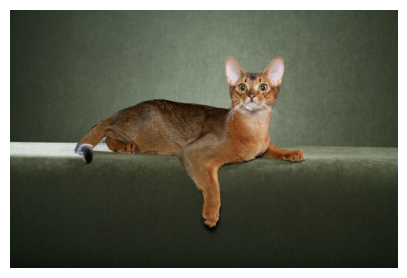

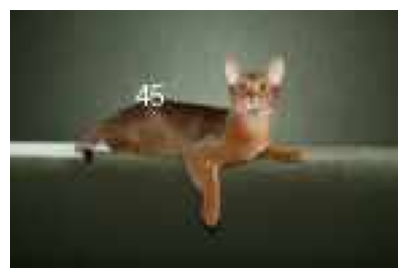

In [14]:
im1.show(); im2.show(figsize=(5,5))

Great! We have some data now! Let's build the `DataBlock`

## DataBlock

In [15]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])

But for today's lesson, we'll go back to that progressive resizing technique we talked about. We want a function that can accept a `batch_size` and a `im_size`. Let's build that:

In [16]:
def get_dls(bs:int, size:int):
  "Generates two `GAN` DataLoaders"
  dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])
  dls = dblock.dataloaders(path_lr, bs=bs, path=path)
  dls.c = 3 # For 3 channel image
  return dls

## Pre-Trained Generator

The goal of this model will be to generate our "Super Resolution" images (or to make an image look better)

In [17]:
dls_gen = get_dls(32, 128)

On the left will be our 'crappified' image, and the right our original

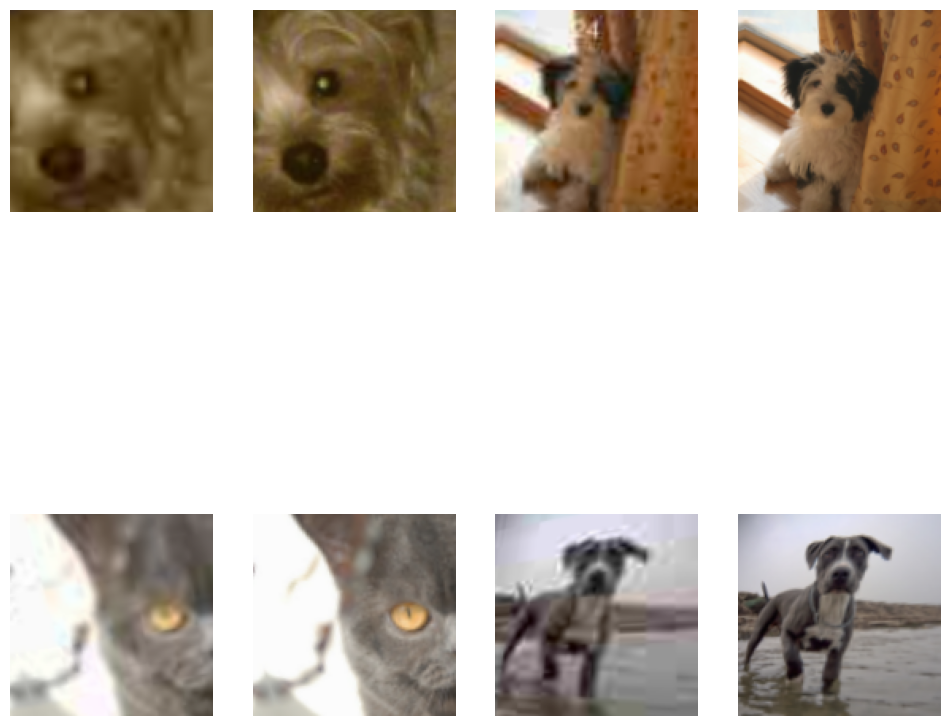

In [18]:
dls_gen.show_batch(max_n=4, figsize=(12,12))

Now let's build some models (with recommended hyper-parameters)

In [19]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

For our backbone, we'll use a resnet34

In [20]:
bbone = resnet34
# cfg = unet_learner(dls_gen,bbone,blur=True, norm_type=NormType.Weight, self_attention=True,
#                   y_range=y_range)

In [21]:
def create_gen_learner():
  return unet_learner(dls_gen, bbone, loss_func=loss_gen,
                      blur=True, norm_type=NormType.Weight, self_attention=True,
                  y_range=y_range)

In [22]:
learn_gen = create_gen_learner()

c:\Users\siddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Let's fit our model quickly (we don't need to train for very long)

In [23]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time


c:\Users\siddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastai\learner.py:448: SyntaxWarning: invalid escape sequence '\R'
  e.args = [f"Custom classes or functions exported with your `Learner` not available in namespace.\Re-declare/import before loading:\n\t{e.args[0]}"]


KeyboardInterrupt: 

Let's unfreeze and fit a bit more!

In [24]:
learn_gen.unfreeze()

In [25]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

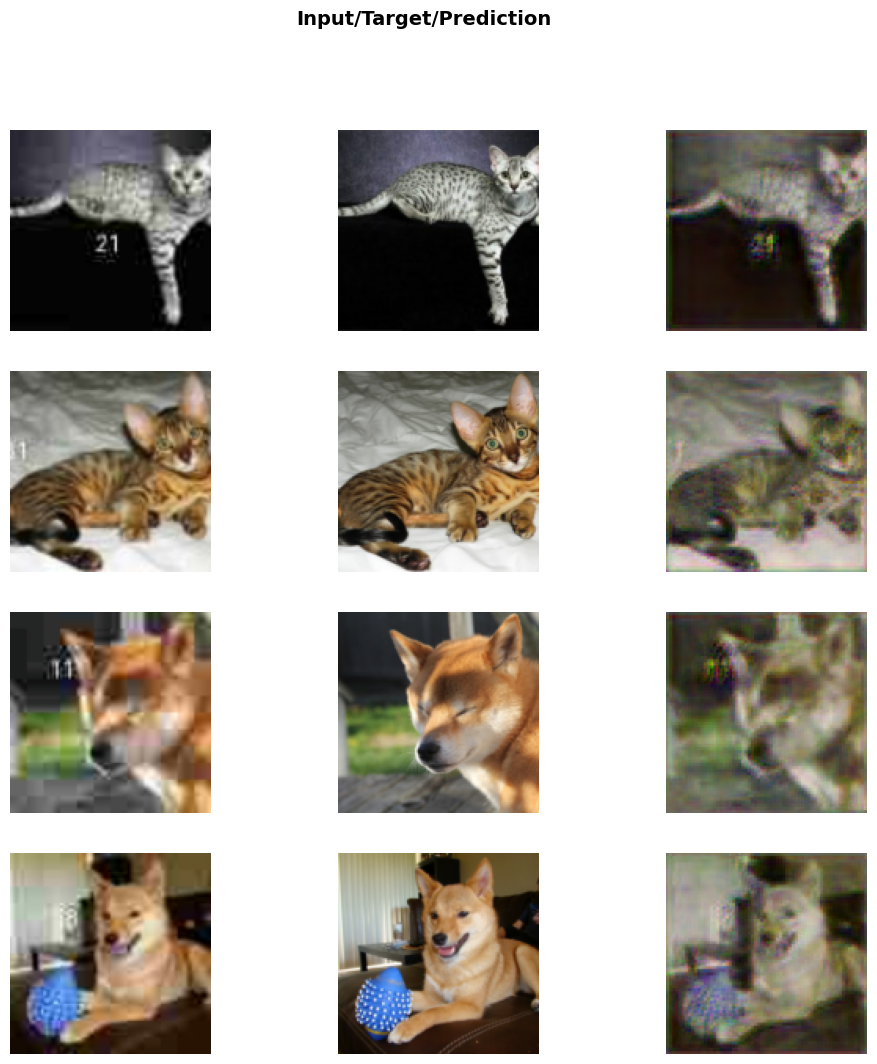

In [26]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [27]:
learn_gen.save('gen-pre2')

Path('C:/Users/siddh/.fastai/data/oxford-iiit-pet/models/gen-pre2.pth')

## Save the generated images

Now we need these generated images saved away so we can use them for our `critic` model. Let's do so:

In [28]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [29]:
path_gen.mkdir(exist_ok=True)

In [30]:
def save_preds(dl, learn):
  "Save away predictions"
  names = dl.dataset.items

  preds,_ = learn.get_preds(dl=dl)
  for i,pred in enumerate(preds):
      dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
      arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
      Image.fromarray(arr).save(path_gen/names[i].name)

We'll want to get rid of any augmentation, `drop_last`, and `shuffle` from our training `DataLoader`:

In [31]:
dl = dls_gen.train.new(shuffle=False, drop_last=False,
                       after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

Now let's look at what we're actually doing

In [32]:
preds, _ = learn_gen.get_preds(dl=dl)

KeyboardInterrupt: 

In [33]:
preds[0].shape

NameError: name 'preds' is not defined

In [ ]:
preds[0][None].shape

torch.Size([1, 3, 128, 128])

In [ ]:
dec = dl.after_batch.decode((TensorImage(preds[0][None]),))[0][0]

In [ ]:
arr = dec.numpy().transpose(1,2,0)

In [34]:
plt.imshow(arr.astype(np.uint8))

NameError: name 'arr' is not defined

Now let's go save it away.

In [ ]:
save_preds(dl, learn_gen)

## Training the critic

Now let's build our critic model

In [36]:
path_gen

Path('C:/Users/siddh/.fastai/data/oxford-iiit-pet/image_gen')

In [37]:
name_gen

'image_gen'

In [38]:
# We have to do this because of a bug for right now
path_g = get_image_files(path/name_gen)
path_i = get_image_files(path/'images')
fnames = path_g + path_i

In [39]:
fnames[0]

Path('C:/Users/siddh/.fastai/data/oxford-iiit-pet/image_gen/Abyssinian_1.jpg')

In [40]:
def get_crit_dls(fnames, bs:int, size:int):
  "Generate two `Critic` DataLoaders"
  splits = RandomSplitter(0.1)(fnames)
  dsrc = Datasets(fnames, tfms=[[PILImage.create], [parent_label, Categorize]],
                 splits=splits)
  tfms = [ToTensor(), Resize(size)]
  gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
  return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms)

In [41]:
dls_crit = get_crit_dls(fnames, bs=32, size=128)

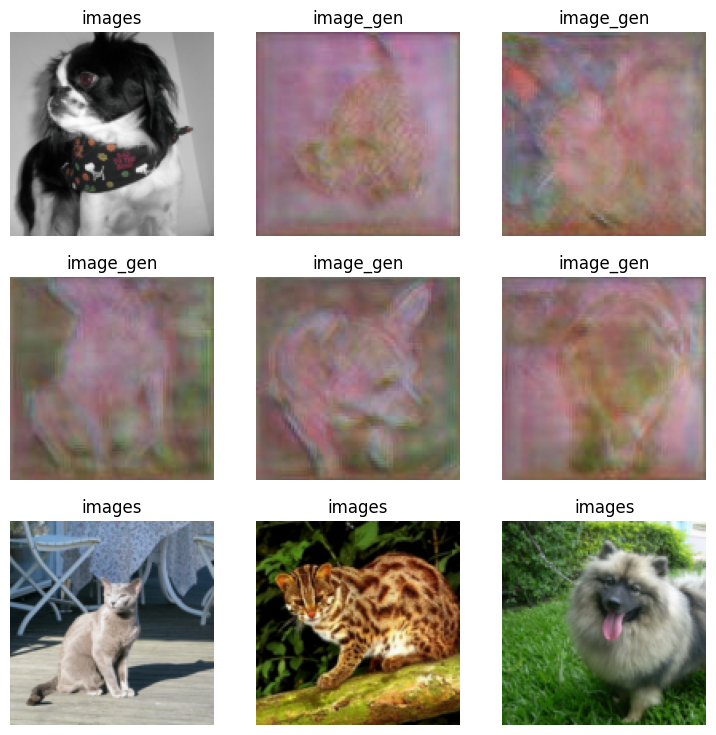

In [42]:
dls_crit.show_batch()

In [43]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [44]:
def create_crit_learner(dls, metrics):
  return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_crit)

In [45]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

And now let's fit!

In [46]:
learn_crit.fit_one_cycle(6, 1e-3, wd=wd)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.287866,0.268594,0.899973,03:04
1,0.255827,0.242725,0.905061,03:14
2,0.178452,0.117600,0.954014,03:07
3,0.066789,0.063774,0.978966,02:56
4,0.034680,0.017910,0.993388,03:09
5,0.014073,0.010307,0.995510,03:11


In [47]:
learn_crit.save('critic-pre2')

Path('models/critic-pre2.pth')

## The GAN

Now we'll combine the two models together into a gan

In [48]:
ls_crit = get_crit_dls(fnames, bs=32, size=128)

In [49]:
learn_crit = create_crit_learner(dls_crit, metrics=None).load('critic-pre2')

In [50]:
learn_gen = create_gen_learner().load('gen-pre2')

The last thing to do is to define our GAN. We are going to do this from_learners, and specifiy which is the generator and which is the critic. The switcher is a callback that decides **when to switch from one to another**.

Here, we will do as many iterations of the discrimitor as needed until its loss is back to <0.65 then do an iteration of generator.

The loss function of the critic is learn_crit's loss function. We take the average on the batch of real (targ 1) and fake (targ 0) predictions.

The loss function of the generator is a weighted sum of the learn_crit.loss_func on the **fake** image batch with a target of 1, and learn_gen.loss_func is applied to the output and target, batch of fake and batch of super-res images.

In [51]:
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training:
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

Let's make our switcher and the `GANLearner`

In [52]:
switcher = AdaptiveGANSwitcher(critic_thresh=.65)

In [53]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.))

In [54]:
lr = 1e-3

And fit!

In [55]:
learn.fit(3, lr, wd=wd)

c:\Users\siddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastai\callback\core.py:69: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
c:\Users\siddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastai\callback\core.py:69: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
c:\Users\siddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastai\callback\core.py:69: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{na

epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,0.992434,11.565409,11.565409,1.009595,03:34
1,1.083601,11.565406,11.565406,0.899645,03:15
2,1.122100,11.565410,11.565410,0.894844,03:22


In [58]:
learn.save('switcher-GANLEARNER')

Path('C:/Users/siddh/.fastai/data/oxford-iiit-pet/models/switcher-GANLEARNER.pth')

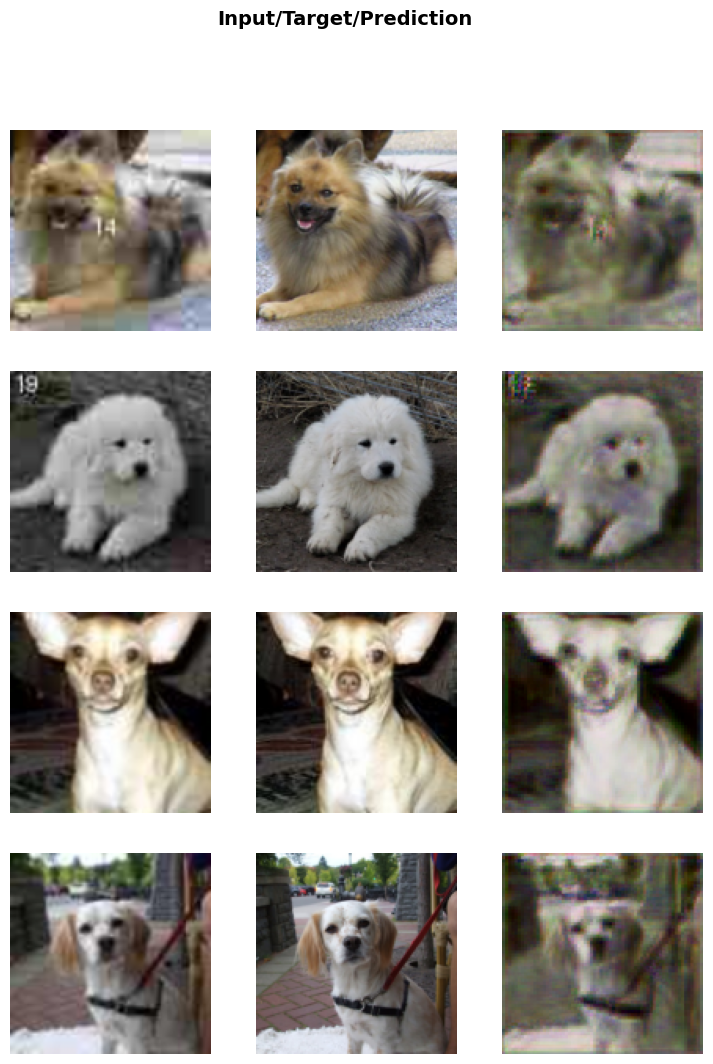

In [56]:
learn.show_results(max_n=4)